In [ ]:
# Lung Cancer Detection Testing Notebook
# This notebook focuses on testing pre-trained YOLOv12 models with edge detection, grayscale processing, and contour analysis

# Cell 1: Installation and Setup
# ==============================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import glob
import random
import time
import yaml
from tqdm.notebook import tqdm
from pathlib import Path
from PIL import Image
from google.colab import files

# Install required packages
!pip install -q ultralytics opencv-python

# Import YOLO library
from ultralytics import YOLO

# Create project directories
base_dir = '/content/lung_cancer_testing'
models_dir = os.path.join(base_dir, 'models')
output_dir = os.path.join(base_dir, 'output')
processed_dir = os.path.join(base_dir, 'processed')

for directory in [base_dir, models_dir, output_dir, processed_dir]:
    os.makedirs(directory, exist_ok=True)

print(f"Directory structure created at {base_dir}")

# Class definitions and pattern explanations
CLASSES = ["adenocarcinoma", "large_cell_carcinoma", "normal", "squamous_cell_carcinoma"]

# Create a data.yaml file for model testing
data_yaml = {
    'names': CLASSES,
    'nc': len(CLASSES)
}

# Save the data.yaml file
with open(os.path.join(base_dir, 'data.yaml'), 'w') as f:
    yaml.dump(data_yaml, f)

print(f"Created data.yaml with classes: {CLASSES}")

# Global variables for model explanations
CANCER_PATTERN_EXPLANATIONS = {
    "adenocarcinoma": [
        "Ground glass opacities - areas of hazy increased opacity",
        "Subsolid nodules with part-solid components",
        "Peripheral lesions that can have speculated margins",
        "More commonly found in the outer third of the lung",
        "May present with air bronchograms (air-filled bronchi visible within the mass)"
    ],
    "large_cell_carcinoma": [
        "Large, poorly circumscribed masses",
        "Typically peripheral in location",
        "Rapid growth and extensive local invasion",
        "Heterogeneous density with areas of necrosis",
        "Less likely to have calcifications"
    ],
    "squamous_cell_carcinoma": [
        "Central masses arising from main or lobar bronchi",
        "May show cavitation (hollow space within the mass)",
        "Associated with hilar masses or enlarged lymph nodes",
        "Can present with post-obstructive pneumonia or atelectasis",
        "More likely to show calcifications"
    ],
    "normal": [
        "No visible masses, nodules, or suspicious lesions",
        "Normal lung parenchyma with visible branching bronchial and vascular structures",
        "Regular bronchial walls and blood vessels tapering normally",
        "Normal mediastinal contours",
        "Clear lung fields without consolidation, infiltrates, or significant opacities"
    ]
}

Directory structure created at /content/lung_cancer_testing
Created data.yaml with classes: ['adenocarcinoma', 'large_cell_carcinoma', 'normal', 'squamous_cell_carcinoma']


In [ ]:


# Cell 2: Enhanced Image Processing Functions
# ===========================================

def enhanced_preprocess_image(image_path, size=(640, 640), use_edge_detection=True, use_grayscale=True):
    """
    Enhanced preprocessing with edge detection and grayscale options

    Args:
        image_path: Path to the image file
        size: Target size for the image (width, height)
        use_edge_detection: Whether to apply edge detection
        use_grayscale: Whether to convert to grayscale

    Returns:
        Preprocessed image and edge map (if requested)
    """
    try:
        # Read the image
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Could not read image from {image_path}")
            return None, None

        # Convert to grayscale if requested
        if use_grayscale:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Create 3-channel grayscale for compatibility with model
            img = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
        else:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Apply edge detection if requested
        edge_map = None
        if use_edge_detection:
            # Apply Gaussian blur to reduce noise
            blurred = cv2.GaussianBlur(gray, (5, 5), 0)

            # Canny edge detection with automatic threshold based on image median
            median_val = np.median(blurred)
            lower = int(max(0, 0.66 * median_val))
            upper = int(min(255, 1.33 * median_val))
            edge_map = cv2.Canny(blurred, lower, upper)

            # Enhance original image with edge information
            # Convert edge map to 3 channels
            edge_map_colored = cv2.cvtColor(edge_map, cv2.COLOR_GRAY2RGB)

            # Combine edge information with original image
            # Using weighted addition to highlight edges while preserving original content
            img = cv2.addWeighted(img, 0.7, edge_map_colored, 0.3, 0)

        # Resize to the target size
        img = cv2.resize(img, size)
        if edge_map is not None:
            edge_map = cv2.resize(edge_map, size)

        return img, edge_map

    except Exception as e:
        print(f"Error preprocessing image: {e}")
        return None, None

def analyze_contours(image, edge_map=None, min_area=100):
    """
    Analyze contours in the image to highlight potential nodules

    Args:
        image: Input image
        edge_map: Pre-computed edge map (if None, calculated from image)
        min_area: Minimum contour area to consider

    Returns:
        Image with contours, contour features dictionary
    """
    # Create a copy for drawing
    contour_img = image.copy()

    # If no edge map provided, create one
    if edge_map is None:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        edge_map = cv2.Canny(blurred, 50, 150)

    # Find contours
    contours, hierarchy = cv2.findContours(edge_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter and analyze contours
    contour_features = []
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area < min_area:
            continue

        # Calculate contour features
        perimeter = cv2.arcLength(contour, True)
        circularity = 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0

        # Get bounding rectangle
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / h if h > 0 else 0

        # Draw contour with unique color based on circularity (more circular = more red)
        color = (int(255 * (1-circularity)), int(255 * (circularity > 0.5)), int(255 * circularity))
        cv2.drawContours(contour_img, [contour], -1, color, 2)

        # Store features
        contour_features.append({
            'id': i,
            'area': area,
            'perimeter': perimeter,
            'circularity': circularity,
            'aspect_ratio': aspect_ratio,
            'boundingRect': (x, y, w, h)
        })

    # Sort contours by area (largest first)
    contour_features.sort(key=lambda x: x['area'], reverse=True)

    return contour_img, contour_features

Loading model from /content/lung_cancer_testing/models/best.pt...
Model loaded successfully!
Model type: <bound method Module.type of YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64

Saving adcc.jpg to adcc.jpg

image 1/1 /content/lung_cancer_testing/processed/temp_adcc.jpg: 640x640 1 adenocarcinoma, 1 normal, 436.5ms
Speed: 7.2ms preprocess, 436.5ms inference, 29.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/adcc.jpg: 512x640 1 adenocarcinoma, 202.7ms
Speed: 3.0ms preprocess, 202.7ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)
Prediction completed in 9.84 seconds


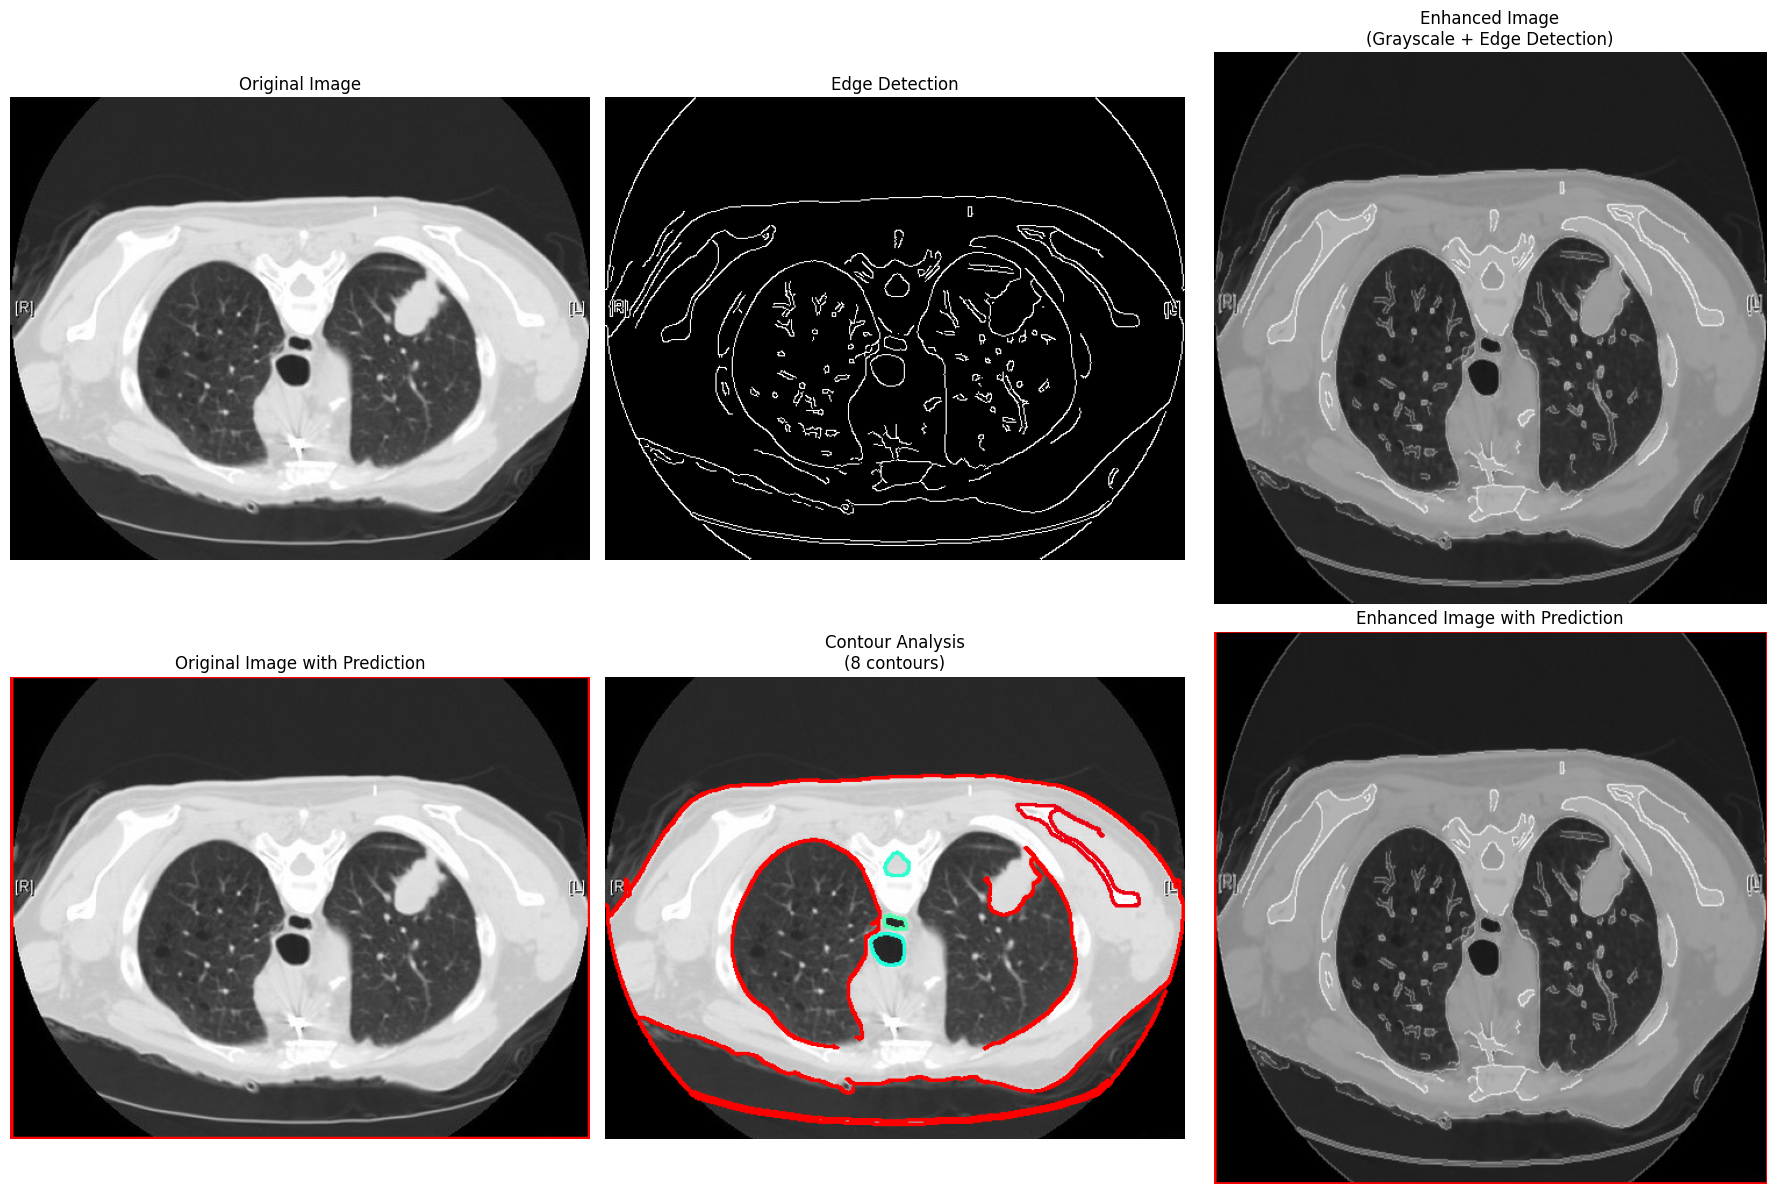


=== Prediction Results ===

Original Image Predictions:
  1. Class: adenocarcinoma, Confidence: 0.8268

Enhanced Image Predictions:
  1. Class: adenocarcinoma, Confidence: 0.6872
  2. Class: normal, Confidence: 0.5196

=== Contour Analysis ===
Found 8 significant contours
  Contour 1: irregular, Area=228717.0px², Circularity=0.18
  Contour 2: irregular, Area=772.5px², Circularity=0.02
  Contour 3: irregular, Area=655.5px², Circularity=0.02
  Contour 4: irregular, Area=246.0px², Circularity=0.07
  Contour 5: irregular, Area=240.0px², Circularity=0.09


In [ ]:
# Cell: Model Loading and Testing with Advanced Image Processing
# ===========================================================

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import random
import time
from google.colab import files
from ultralytics import YOLO

# Create processed directory if it doesn't exist
processed_dir = os.path.join('/content/lung_cancer_testing', 'processed')
os.makedirs(processed_dir, exist_ok=True)

# Enhanced Image Processing Functions
def enhanced_preprocess_image(image_path, size=(640, 640), use_edge_detection=True, use_grayscale=True):
    """Enhanced preprocessing with edge detection and grayscale options"""
    try:
        # Read the image
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Could not read image from {image_path}")
            return None, None

        # Store original for visualization
        original = img.copy()

        # Convert to grayscale if requested
        if use_grayscale:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Create 3-channel grayscale for compatibility with model
            img = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
        else:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Apply edge detection if requested
        edge_map = None
        if use_edge_detection:
            # Apply Gaussian blur to reduce noise
            blurred = cv2.GaussianBlur(gray, (5, 5), 0)

            # Canny edge detection with automatic threshold based on image median
            median_val = np.median(blurred)
            lower = int(max(0, 0.66 * median_val))
            upper = int(min(255, 1.33 * median_val))
            edge_map = cv2.Canny(blurred, lower, upper)

            # Convert edge map to 3 channels
            edge_map_colored = cv2.cvtColor(edge_map, cv2.COLOR_GRAY2RGB)

            # Combine edge information with original image
            img = cv2.addWeighted(img, 0.7, edge_map_colored, 0.3, 0)

        # Resize to the target size
        img = cv2.resize(img, size)
        if edge_map is not None:
            edge_map = cv2.resize(edge_map, size)

        return img, edge_map

    except Exception as e:
        print(f"Error preprocessing image: {e}")
        return None, None

def analyze_contours(image, edge_map=None, min_area=100):
    """Analyze contours in the image to highlight potential nodules"""
    # Create a copy for drawing
    contour_img = image.copy()

    # If no edge map provided, create one
    if edge_map is None:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        edge_map = cv2.Canny(blurred, 50, 150)

    # Find contours
    contours, hierarchy = cv2.findContours(edge_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter and analyze contours
    contour_features = []
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area < min_area:
            continue

        # Calculate contour features
        perimeter = cv2.arcLength(contour, True)
        circularity = 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0

        # Get bounding rectangle
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / h if h > 0 else 0

        # Draw contour with unique color based on circularity (more circular = more red)
        color = (int(255 * (1-circularity)), int(255 * (circularity > 0.5)), int(255 * circularity))
        cv2.drawContours(contour_img, [contour], -1, color, 2)

        # Store features
        contour_features.append({
            'id': i,
            'area': area,
            'perimeter': perimeter,
            'circularity': circularity,
            'aspect_ratio': aspect_ratio,
            'boundingRect': (x, y, w, h)
        })

    # Sort contours by area (largest first)
    contour_features.sort(key=lambda x: x['area'], reverse=True)

    return contour_img, contour_features

# Model Loading and Prediction Functions
def load_yolo_model(model_path):
    """Load a YOLO model from a specified path"""
    if not os.path.exists(model_path):
        print(f"Error: Model file not found at {model_path}")
        return None

    try:
        print(f"Loading model from {model_path}...")
        model = YOLO(model_path)

        # Print the model's class names
        print(f"Model loaded successfully!")
        print(f"Model type: {model.type}")
        print(f"Model classes: {model.names}")

        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

def upload_test_image():
    """Upload a test image"""
    print("Please upload a lung CT scan image to test:")
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded")
        return None

    image_file = list(uploaded.keys())[0]
    return image_file

def optimized_predict(model, image_path, conf_threshold=0.25):
    """Optimized prediction with enhanced image processing"""
    if not os.path.exists(image_path):
        print(f"Error: Image not found: {image_path}")
        return None, None, None

    try:
        # Start timing
        start_time = time.time()

        # Apply enhanced preprocessing
        processed_img, edge_map = enhanced_preprocess_image(image_path)
        if processed_img is None:
            return None, None, None

        # Save processed image to temporary file for YOLO
        temp_file = os.path.join(processed_dir, f"temp_{os.path.basename(image_path)}")
        cv2.imwrite(temp_file, cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR))

        # Apply contour analysis
        contour_img, contour_features = analyze_contours(processed_img, edge_map)

        # Run YOLO prediction on processed image
        results = model.predict(temp_file, conf=conf_threshold)[0]

        # Run YOLO prediction on original image for comparison
        orig_results = model.predict(image_path, conf=conf_threshold)[0]

        # Remove temporary file
        if os.path.exists(temp_file):
            os.remove(temp_file)

        # Calculate processing time
        processing_time = time.time() - start_time
        print(f"Prediction completed in {processing_time:.2f} seconds")

        return results, processed_img, contour_features, orig_results

    except Exception as e:
        print(f"Error during prediction: {e}")
        return None, None, None, None

def visualize_comprehensive_analysis(model, image_path, conf_threshold=0.25):
    """Comprehensive visualization with edge detection, grayscale, and contour analysis"""
    # Load the original image
    orig_img = cv2.imread(image_path)
    if orig_img is None:
        print(f"Error: Could not read image from {image_path}")
        return

    # Run enhanced prediction
    results, processed_img, contour_features, orig_results = optimized_predict(
        model, image_path, conf_threshold)

    if results is None or processed_img is None:
        print("Error in prediction. Please check the image and model.")
        return

    # Convert original image to RGB for display
    rgb_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    # Create grayscale version
    gray_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)

    # Apply edge detection
    blurred = cv2.GaussianBlur(gray_img, (5, 5), 0)
    median_val = np.median(blurred)
    lower = int(max(0, 0.66 * median_val))
    upper = int(min(255, 1.33 * median_val))
    edge_map = cv2.Canny(blurred, lower, upper)

    # Create prediction visualization on original image
    orig_pred_img = rgb_img.copy()
    if orig_results and len(orig_results.boxes) > 0:
        for box in orig_results.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = float(box.conf[0])
            cls_id = int(box.cls[0])
            cls_name = model.names[cls_id]

            # Draw rectangle
            cv2.rectangle(orig_pred_img, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

            # Add label
            label = f"{cls_name} {conf:.2f}"
            cv2.putText(orig_pred_img, label, (int(x1), int(y1)-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Create prediction visualization on processed image
    proc_pred_img = processed_img.copy()
    if results and len(results.boxes) > 0:
        for box in results.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = float(box.conf[0])
            cls_id = int(box.cls[0])
            cls_name = model.names[cls_id]

            # Draw rectangle
            cv2.rectangle(proc_pred_img, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

            # Add label
            label = f"{cls_name} {conf:.2f}"
            cv2.putText(proc_pred_img, label, (int(x1), int(y1)-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Set up the main figure with 2x3 grid
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Original Image
    axes[0, 0].imshow(rgb_img)
    axes[0, 0].set_title("Original Image")
    axes[0, 0].axis('off')

    # Edge Detection
    axes[0, 1].imshow(edge_map, cmap='gray')
    axes[0, 1].set_title("Edge Detection")
    axes[0, 1].axis('off')

    # Enhanced Image (Grayscale + Edge)
    axes[0, 2].imshow(processed_img)
    axes[0, 2].set_title("Enhanced Image\n(Grayscale + Edge Detection)")
    axes[0, 2].axis('off')

    # Original Image with Prediction
    axes[1, 0].imshow(orig_pred_img)
    axes[1, 0].set_title("Original Image with Prediction")
    axes[1, 0].axis('off')

    # Contour Analysis
    contour_img, _ = analyze_contours(rgb_img.copy(), edge_map)
    axes[1, 1].imshow(contour_img)
    axes[1, 1].set_title(f"Contour Analysis\n({len(contour_features)} contours)")
    axes[1, 1].axis('off')

    # Enhanced Image with Prediction
    axes[1, 2].imshow(proc_pred_img)
    axes[1, 2].set_title("Enhanced Image with Prediction")
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

    # Print prediction results
    print("\n=== Prediction Results ===")

    print("\nOriginal Image Predictions:")
    if orig_results and len(orig_results.boxes) > 0:
        for i, box in enumerate(orig_results.boxes):
            conf = float(box.conf[0])
            cls_id = int(box.cls[0])
            cls_name = model.names[cls_id]
            print(f"  {i+1}. Class: {cls_name}, Confidence: {conf:.4f}")
    else:
        print("  No detections found")

    print("\nEnhanced Image Predictions:")
    if results and len(results.boxes) > 0:
        for i, box in enumerate(results.boxes):
            conf = float(box.conf[0])
            cls_id = int(box.cls[0])
            cls_name = model.names[cls_id]
            print(f"  {i+1}. Class: {cls_name}, Confidence: {conf:.4f}")
    else:
        print("  No detections found")

    # Print contour analysis
    if contour_features:
        print("\n=== Contour Analysis ===")
        print(f"Found {len(contour_features)} significant contours")
        for i, cf in enumerate(contour_features[:5]):  # Show top 5 contours
            shape_desc = "circular" if cf['circularity'] > 0.7 else "irregular"
            print(f"  Contour {i+1}: {shape_desc}, Area={cf['area']:.1f}px², "
                  f"Circularity={cf['circularity']:.2f}")

    return results

# Load the model
model_path = "/content/lung_cancer_testing/models/best.pt"
model = load_yolo_model(model_path)

# If model loaded successfully, prompt for test image
if model is not None:
    test_img = upload_test_image()
    if test_img:
        # Run comprehensive analysis
        visualize_comprehensive_analysis(model, test_img)

Loading model from /content/lung_cancer_testing/models/best.pt...
Model loaded successfully!
Model type: <bound method Module.type of YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64

Saving sqm.jpg to sqm.jpg
Loading model from /content/lung_cancer_testing/models/best.pt...
Model loaded successfully!
Model type: <bound method Module.type of YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
     

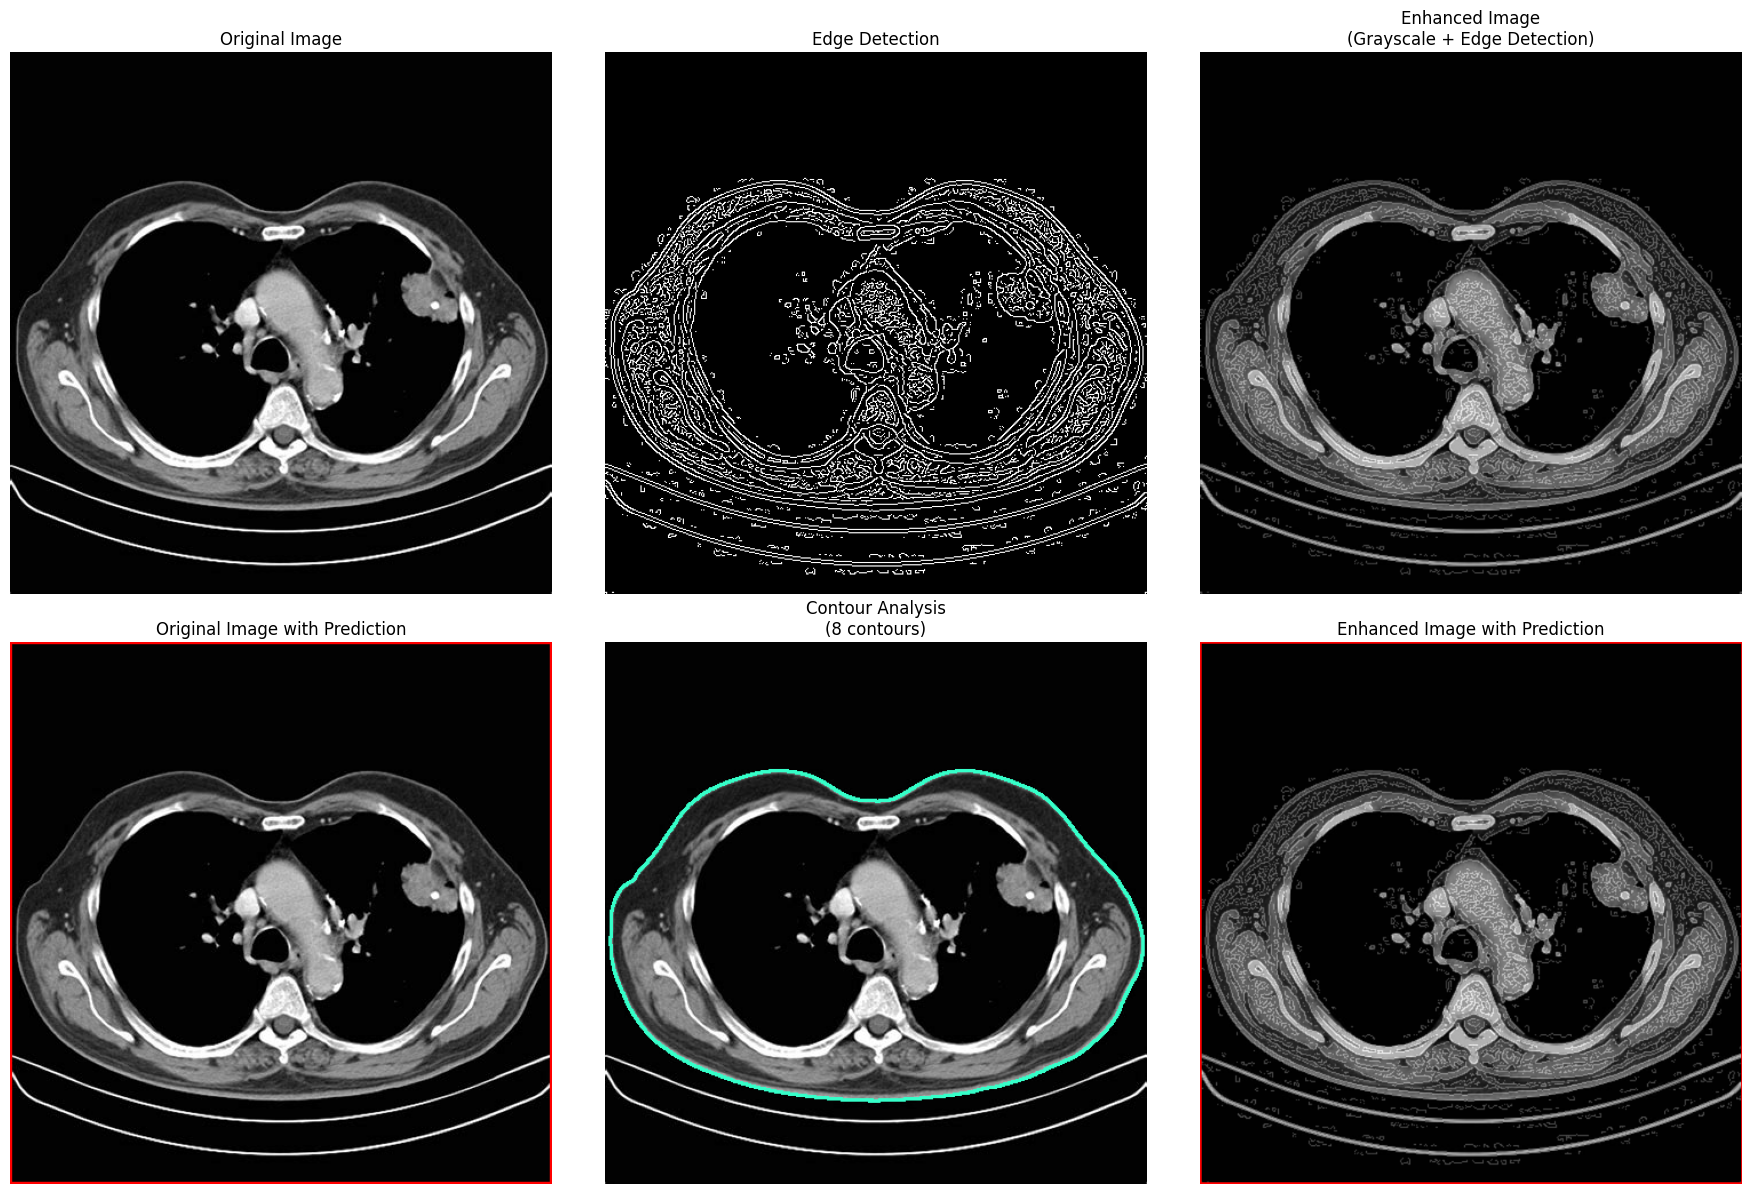


=== Prediction Results ===

Original Image Predictions:
  1. Class: squamous_cell_carcinoma, Confidence: 0.4976
  2. Class: normal, Confidence: 0.4847

Enhanced Image Predictions:
  1. Class: normal, Confidence: 0.8752

=== Contour Analysis ===
Found 8 significant contours
  Contour 1: irregular, Area=196742.0px², Circularity=0.62
  Contour 2: irregular, Area=4122.5px², Circularity=0.02
  Contour 3: irregular, Area=3923.0px², Circularity=0.02
  Contour 4: irregular, Area=214.5px², Circularity=0.08
  Contour 5: irregular, Area=159.5px², Circularity=0.20

Detection Results:

Detection 1: normal (NON-CANCER) with confidence 0.88

Contour Analysis Observations:
  - Contour 1: irregular shape with area 196742.0px²
  - Contour 2: irregular shape with area 4122.5px²
  - Contour 3: irregular shape with area 3923.0px²


In [ ]:
# Cell: Complete Lung Cancer Detection Testing with Fixed Functions
# ================================================================

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import random
import time
from google.colab import files
from ultralytics import YOLO

# Create processed directory if it doesn't exist
processed_dir = os.path.join('/content/lung_cancer_testing', 'processed')
os.makedirs(processed_dir, exist_ok=True)

# Enhanced Image Processing Functions
def enhanced_preprocess_image(image_path, size=(640, 640), use_edge_detection=True, use_grayscale=True):
    """Enhanced preprocessing with edge detection and grayscale options"""
    try:
        # Read the image
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Could not read image from {image_path}")
            return None, None

        # Store original for visualization
        original = img.copy()

        # Convert to grayscale if requested
        if use_grayscale:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Create 3-channel grayscale for compatibility with model
            img = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
        else:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Apply edge detection if requested
        edge_map = None
        if use_edge_detection:
            # Apply Gaussian blur to reduce noise
            blurred = cv2.GaussianBlur(gray, (5, 5), 0)

            # Canny edge detection with automatic threshold based on image median
            median_val = np.median(blurred)
            lower = int(max(0, 0.66 * median_val))
            upper = int(min(255, 1.33 * median_val))
            edge_map = cv2.Canny(blurred, lower, upper)

            # Convert edge map to 3 channels
            edge_map_colored = cv2.cvtColor(edge_map, cv2.COLOR_GRAY2RGB)

            # Combine edge information with original image
            img = cv2.addWeighted(img, 0.7, edge_map_colored, 0.3, 0)

        # Resize to the target size
        img = cv2.resize(img, size)
        if edge_map is not None:
            edge_map = cv2.resize(edge_map, size)

        return img, edge_map

    except Exception as e:
        print(f"Error preprocessing image: {e}")
        return None, None

def analyze_contours(image, edge_map=None, min_area=100):
    """Analyze contours in the image to highlight potential nodules"""
    # Create a copy for drawing
    contour_img = image.copy()

    # If no edge map provided, create one
    if edge_map is None:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        edge_map = cv2.Canny(blurred, 50, 150)

    # Find contours
    contours, hierarchy = cv2.findContours(edge_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter and analyze contours
    contour_features = []
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area < min_area:
            continue

        # Calculate contour features
        perimeter = cv2.arcLength(contour, True)
        circularity = 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0

        # Get bounding rectangle
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / h if h > 0 else 0

        # Draw contour with unique color based on circularity (more circular = more red)
        color = (int(255 * (1-circularity)), int(255 * (circularity > 0.5)), int(255 * circularity))
        cv2.drawContours(contour_img, [contour], -1, color, 2)

        # Store features
        contour_features.append({
            'id': i,
            'area': area,
            'perimeter': perimeter,
            'circularity': circularity,
            'aspect_ratio': aspect_ratio,
            'boundingRect': (x, y, w, h)
        })

    # Sort contours by area (largest first)
    contour_features.sort(key=lambda x: x['area'], reverse=True)

    return contour_img, contour_features

# Model Loading and Prediction Functions
def load_yolo_model(model_path):
    """Load a YOLO model from a specified path"""
    if not os.path.exists(model_path):
        print(f"Error: Model file not found at {model_path}")
        return None

    try:
        print(f"Loading model from {model_path}...")
        model = YOLO(model_path)

        # Print the model's class names
        print(f"Model loaded successfully!")
        print(f"Model type: {model.type}")
        print(f"Model classes: {model.names}")

        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

def upload_model():
    """Function to upload a model file"""
    print("Please upload your trained YOLOv12 model file (best.pt):")
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded")
        return None

    model_file = list(uploaded.keys())[0]

    # Save uploaded model to models directory
    model_path = os.path.join('/content/lung_cancer_testing/models', model_file)
    with open(model_path, 'wb') as f:
        f.write(uploaded[model_file])

    print(f"Model saved to {model_path}")
    return model_path

def upload_test_image():
    """Upload a test image"""
    print("Please upload a lung CT scan image to test:")
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded")
        return None

    image_file = list(uploaded.keys())[0]
    return image_file

def optimized_predict(model, image_path, conf_threshold=0.25):
    """Optimized prediction with enhanced image processing"""
    if not os.path.exists(image_path):
        print(f"Error: Image not found: {image_path}")
        return None, None, None, None

    try:
        # Start timing
        start_time = time.time()

        # Apply enhanced preprocessing
        processed_img, edge_map = enhanced_preprocess_image(image_path)
        if processed_img is None:
            return None, None, None, None

        # Save processed image to temporary file for YOLO
        temp_file = os.path.join(processed_dir, f"temp_{os.path.basename(image_path)}")
        cv2.imwrite(temp_file, cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR))

        # Apply contour analysis
        contour_img, contour_features = analyze_contours(processed_img, edge_map)

        # Run YOLO prediction on processed image
        results = model.predict(temp_file, conf=conf_threshold)[0]

        # Run YOLO prediction on original image for comparison
        orig_results = model.predict(image_path, conf=conf_threshold)[0]

        # Remove temporary file
        if os.path.exists(temp_file):
            os.remove(temp_file)

        # Calculate processing time
        processing_time = time.time() - start_time
        print(f"Prediction completed in {processing_time:.2f} seconds")

        return results, processed_img, contour_features, orig_results

    except Exception as e:
        print(f"Error during prediction: {e}")
        return None, None, None, None

def visualize_comprehensive_analysis(model, image_path, conf_threshold=0.25):
    """Comprehensive visualization with edge detection, grayscale, and contour analysis"""
    # Load the original image
    orig_img = cv2.imread(image_path)
    if orig_img is None:
        print(f"Error: Could not read image from {image_path}")
        return

    # Run enhanced prediction
    results, processed_img, contour_features, orig_results = optimized_predict(
        model, image_path, conf_threshold)

    if results is None or processed_img is None:
        print("Error in prediction. Please check the image and model.")
        return

    # Convert original image to RGB for display
    rgb_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    # Create grayscale version
    gray_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)

    # Apply edge detection
    blurred = cv2.GaussianBlur(gray_img, (5, 5), 0)
    median_val = np.median(blurred)
    lower = int(max(0, 0.66 * median_val))
    upper = int(min(255, 1.33 * median_val))
    edge_map = cv2.Canny(blurred, lower, upper)

    # Create prediction visualization on original image
    orig_pred_img = rgb_img.copy()
    if orig_results and len(orig_results.boxes) > 0:
        for box in orig_results.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = float(box.conf[0])
            cls_id = int(box.cls[0])
            cls_name = model.names[cls_id]

            # Draw rectangle
            cv2.rectangle(orig_pred_img, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

            # Add label
            label = f"{cls_name} {conf:.2f}"
            cv2.putText(orig_pred_img, label, (int(x1), int(y1)-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Create prediction visualization on processed image
    proc_pred_img = processed_img.copy()
    if results and len(results.boxes) > 0:
        for box in results.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = float(box.conf[0])
            cls_id = int(box.cls[0])
            cls_name = model.names[cls_id]

            # Draw rectangle
            cv2.rectangle(proc_pred_img, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

            # Add label
            label = f"{cls_name} {conf:.2f}"
            cv2.putText(proc_pred_img, label, (int(x1), int(y1)-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Set up the main figure with 2x3 grid
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Original Image
    axes[0, 0].imshow(rgb_img)
    axes[0, 0].set_title("Original Image")
    axes[0, 0].axis('off')

    # Edge Detection
    axes[0, 1].imshow(edge_map, cmap='gray')
    axes[0, 1].set_title("Edge Detection")
    axes[0, 1].axis('off')

    # Enhanced Image (Grayscale + Edge)
    axes[0, 2].imshow(processed_img)
    axes[0, 2].set_title("Enhanced Image\n(Grayscale + Edge Detection)")
    axes[0, 2].axis('off')

    # Original Image with Prediction
    axes[1, 0].imshow(orig_pred_img)
    axes[1, 0].set_title("Original Image with Prediction")
    axes[1, 0].axis('off')

    # Contour Analysis
    contour_img, _ = analyze_contours(rgb_img.copy(), edge_map)
    axes[1, 1].imshow(contour_img)
    axes[1, 1].set_title(f"Contour Analysis\n({len(contour_features)} contours)")
    axes[1, 1].axis('off')

    # Enhanced Image with Prediction
    axes[1, 2].imshow(proc_pred_img)
    axes[1, 2].set_title("Enhanced Image with Prediction")
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

    # Print prediction results
    print("\n=== Prediction Results ===")

    print("\nOriginal Image Predictions:")
    if orig_results and len(orig_results.boxes) > 0:
        for i, box in enumerate(orig_results.boxes):
            conf = float(box.conf[0])
            cls_id = int(box.cls[0])
            cls_name = model.names[cls_id]
            print(f"  {i+1}. Class: {cls_name}, Confidence: {conf:.4f}")
    else:
        print("  No detections found")

    print("\nEnhanced Image Predictions:")
    if results and len(results.boxes) > 0:
        for i, box in enumerate(results.boxes):
            conf = float(box.conf[0])
            cls_id = int(box.cls[0])
            cls_name = model.names[cls_id]
            print(f"  {i+1}. Class: {cls_name}, Confidence: {conf:.4f}")
    else:
        print("  No detections found")

    # Print contour analysis
    if contour_features:
        print("\n=== Contour Analysis ===")
        print(f"Found {len(contour_features)} significant contours")
        for i, cf in enumerate(contour_features[:5]):  # Show top 5 contours
            shape_desc = "circular" if cf['circularity'] > 0.7 else "irregular"
            print(f"  Contour {i+1}: {shape_desc}, Area={cf['area']:.1f}px², "
                  f"Circularity={cf['circularity']:.2f}")

    return results

def enhanced_lung_cancer_detection(image_path, model_path=None, conf_threshold=0.25):
    """
    Enhanced lung cancer detection with edge detection, grayscale, and contour analysis
    """
    # Load model
    if model_path is None:
        model_path = upload_model()
        if not model_path:
            return

    model = load_yolo_model(model_path)
    if model is None:
        return

    # Process the image and get predictions - fixed function call
    results, processed_img, contour_features, orig_results = optimized_predict(
        model, image_path, conf_threshold)

    if results is None:
        print("Error in prediction. Please check the image and model.")
        return

    # Visualize the analysis
    visualize_comprehensive_analysis(model, image_path, conf_threshold)

    # Display the prediction results
    boxes = results.boxes
    if len(boxes) == 0:
        print("No lung abnormalities detected.")
        return

    print("\nDetection Results:")
    for i, box in enumerate(boxes):
        conf = float(box.conf[0])
        cls_id = int(box.cls[0])
        cls_name = model.names[cls_id]
        cancer_status = "CANCER" if cls_name != "normal" else "NON-CANCER"

        print(f"\nDetection {i+1}: {cls_name} ({cancer_status}) with confidence {conf:.2f}")

        # Make contour-based observations if we have contours
        if contour_features:
            # Find contours that overlap with the detection box
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            overlapping_contours = []

            for cf in contour_features:
                cx, cy, cw, ch = cf['boundingRect']
                # Check for overlap
                if (cx < x2 and cx + cw > x1 and cy < y2 and cy + ch > y1):
                    overlapping_contours.append(cf)

            if overlapping_contours:
                print("\nContour Analysis Observations:")
                for j, cf in enumerate(overlapping_contours[:3]):  # Show top 3 overlapping contours
                    shape_desc = "circular" if cf['circularity'] > 0.7 else "irregular"
                    print(f"  - Contour {j+1}: {shape_desc} shape with "
                          f"area {cf['area']:.1f}px²")

                # Make observations based on contour analysis
                avg_circularity = sum(cf['circularity'] for cf in overlapping_contours) / len(overlapping_contours)
                if avg_circularity > 0.7 and cls_name != "normal":
                    print("  * The high circularity of the contours is consistent with nodular patterns often seen in lung cancers.")
                elif avg_circularity < 0.5 and cls_name != "normal":
                    print("  * The irregular shapes detected may indicate invasive or aggressive features.")

    return results

def test_model():
    """
    Main function to test a YOLOv12 model on lung cancer images
    """
    # Step 1: Upload or select a model
    model_path = "/content/lung_cancer_testing/models/best.pt"  # Use already uploaded model

    # Step 2: Load the model
    model = load_yolo_model(model_path)
    if not model:
        return

    # Step 3: Upload a test image
    image_path = upload_test_image()
    if not image_path:
        return

    # Step 4: Run the enhanced lung cancer detection
    enhanced_lung_cancer_detection(image_path, model_path)

# Run the test function
test_model()

In [ ]:
test_model()

Loading model from /content/lung_cancer_testing/models/best.pt...
Error loading model: PytorchStreamReader failed reading zip archive: failed finding central directory
